In [1]:
from munich_utils import *
from potsdam_utils import map_label2rgb, idx2rgb, idx2label

import torch.nn as nn

import seaborn as sns
import pandas as pd

### DataLoader

In [2]:
# Load config file and get potsdam data path
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
path = config['data']['potsdam']

In [3]:
# Initialize DataLoader for munich
BATCH_SIZE = 8
test_loader = get_munich_test_loader(batch_size=BATCH_SIZE)

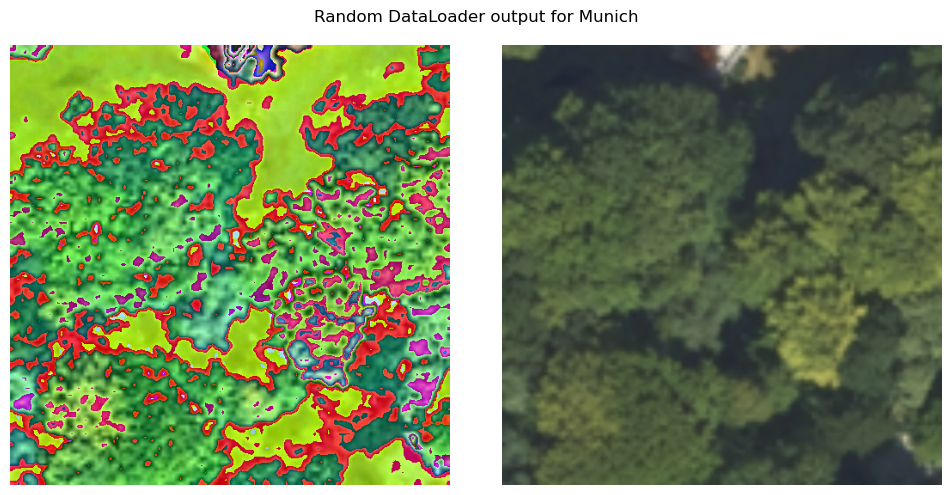

In [4]:
img = next(iter(test_loader))[3,:,:,:]
plot_example(img, "Random DataLoader output for Munich")

### Inference on Munich

In [5]:
# Device setup
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
print(f"Using {DEVICE} as DEVICE")

# Load the model
model = torch.load(config['data']['model_weights']+'/potsdam_FCN.pth.tar', map_location=torch.device('cpu'))
model = model.to(DEVICE)


Using cuda as DEVICE


In [6]:
if DEVICE == 'cuda':
    # Get all images, targets and predictions for the test set
    img_size = 512
    all_images = np.zeros([BATCH_SIZE*(len(test_loader)-1), 3, img_size, img_size])
    all_predictions = np.zeros([BATCH_SIZE*(len(test_loader)-1), img_size, img_size])

    for idx, data in enumerate(test_loader):
        print(f"Processing batch {idx} of {len(test_loader)-1}")
        if idx != len(test_loader)-1:
            all_images[idx*BATCH_SIZE:((idx+1)*BATCH_SIZE), :, :, :] = data

            # Get model predictions and save them
            model.eval()
            with torch.no_grad():
                data = data.to(DEVICE)
                logits = model(data)['out']
                prob = nn.Softmax(logits).dim
                pred = torch.argmax(prob, dim = 1)
            all_predictions[idx*BATCH_SIZE:((idx+1)*BATCH_SIZE), :, :] = pred.cpu()
    # Dump to pickle for later use
    import pickle
    with open('all_images.pickle', 'wb') as handle:
        pickle.dump(all_images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('all_predictions.pickle', 'wb') as handle:
        pickle.dump(all_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print('No GPU available. Loading the saved pickle files instead...')
    all_images = pickle.load(open("all_images.pickle", "rb"))
    all_predictions = pickle.load(open("all_predictions.pickle", "rb"))


Processing batch 0 of 49
Processing batch 1 of 49
Processing batch 2 of 49
Processing batch 3 of 49
Processing batch 4 of 49
Processing batch 5 of 49
Processing batch 6 of 49
Processing batch 7 of 49
Processing batch 8 of 49
Processing batch 9 of 49
Processing batch 10 of 49
Processing batch 11 of 49
Processing batch 12 of 49
Processing batch 13 of 49
Processing batch 14 of 49
Processing batch 15 of 49
Processing batch 16 of 49
Processing batch 17 of 49
Processing batch 18 of 49
Processing batch 19 of 49
Processing batch 20 of 49
Processing batch 21 of 49
Processing batch 22 of 49
Processing batch 23 of 49
Processing batch 24 of 49
Processing batch 25 of 49
Processing batch 26 of 49
Processing batch 27 of 49
Processing batch 28 of 49
Processing batch 29 of 49
Processing batch 30 of 49
Processing batch 31 of 49
Processing batch 32 of 49
Processing batch 33 of 49
Processing batch 34 of 49
Processing batch 35 of 49
Processing batch 36 of 49
Processing batch 37 of 49
Processing batch 38 of

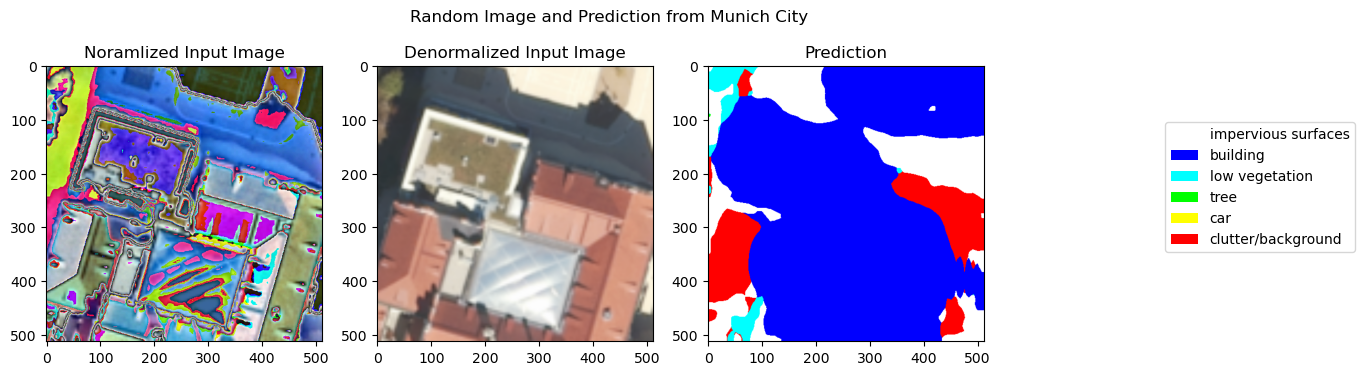

In [60]:
# Plot random instance of the test set
idx = random.randint(0, all_images.shape[0]-1)
img = all_images[idx,:,:,:]
prediction = all_predictions[idx, :, :]

fig, ax = plt.subplots(1,3, figsize = (15,4))
ax[0].imshow(ToPILImage()(torch.from_numpy(img)))
ax[0].set_title('Noramlized Input Image')
ax[1].imshow(ToPILImage()(torch.from_numpy(denormalize_image(img))))
ax[1].set_title('Denormalized Input Image')
ax[2].imshow(map_label2rgb(prediction.astype('int')))
ax[2].set_title('Prediction')
plt.suptitle('Random Image and Prediction from Munich City')

colors = [(r / 255, g / 255, b / 255, 1) for r, g, b in idx2rgb.values()]
labels = [str(idx2label[key]) for key in idx2rgb]

# Create a legend using the extracted colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
fig.legend(patches, labels, loc=7)
fig.subplots_adjust(right=0.75)

plt.show()